In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
# Load and Preprocess the Data

# Load the Google stock prices dataset
data = pd.read_csv("stock_prices.csv")

In [4]:
# Preprocess the data
data['Date'] = pd.to_datetime(data['Date'])
prices = data['Close'].values.reshape(-1, 1)  # Reshape for MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

In [5]:
# Prepare the Data for RNN

# Convert time series data into sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [6]:
seq_length = 10  # Number of time steps to look back
X, y = create_sequences(prices_scaled, seq_length)

In [7]:
# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [8]:
# Build the RNN Model

model = Sequential([
    LSTM(50, activation='tanh', input_shape=(seq_length, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
# Train the RNN Model

epochs = 50
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/50
13/13 [==============================] - 3s 48ms/step - loss: 0.1990 - val_loss: 0.1451
Epoch 2/50
13/13 [==============================] - 0s 6ms/step - loss: 0.0160 - val_loss: 0.0105
Epoch 3/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0096 - val_loss: 0.0113
Epoch 4/50
13/13 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0057
Epoch 5/50
13/13 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 6/50
13/13 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 7/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 8/50
13/13 [==============================] - 0s 9ms/step - loss: 9.1045e-04 - val_loss: 0.0022
Epoch 9/50
13/13 [==============================] - 0s 7ms/step - loss: 8.5434e-04 - val_loss: 0.0026
Epoch 10/50
13/13 [==============================] - 0s 8ms/step - loss: 8.3873e-04 - val_loss: 0.0026
Epoch 

In [10]:
# Evaluate the RNN Model

loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

4/4 [==============================] - 0s 7ms/step - loss: 0.0027
Test Loss: 0.0026619061827659607


In [11]:
# Prediction

# Make predictions on future time steps
future_steps = 30
forecast = []

last_sequence = X[-1]
for _ in range(future_steps):
    pred = model.predict(last_sequence.reshape(1, seq_length, 1))[0][0]
    forecast.append(pred)
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = pred


1/1 [==============================] - 0s 16ms/step


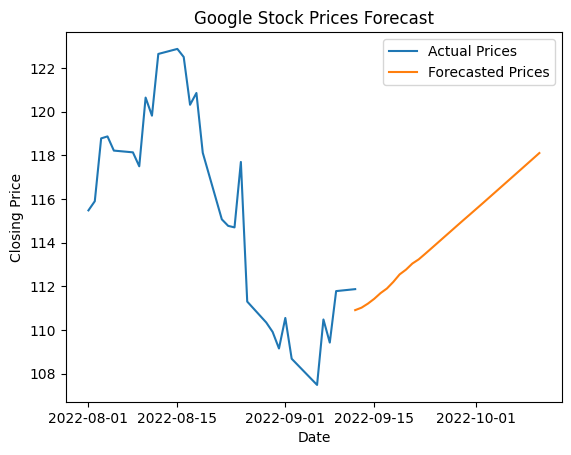

In [12]:
# Inverse transform the scaled forecasted prices
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Plot the forecasted prices
plt.plot(data['Date'][-30:], data['Close'][-30:], label='Actual Prices')
plt.plot(pd.date_range(start=data['Date'].iloc[-1], periods=future_steps), forecast, label='Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Google Stock Prices Forecast')
plt.legend()
plt.show()